In [1]:
%pylab --no-import-all inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# An OCR bag-of-symbols baseline for LaTeX equation images
## Load the equations and images

In [25]:
import skimage.io
from glob import glob
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

equations, images = [], []
for i, line in enumerate(open('enwiki-equations.txt')):
    equations.append( line.strip() )
    images.append( skimage.io.imread('enwiki-equation-images/%s.png'%i, flatten=True)/255.0 )

## Naively parse the equations into bag-of-symbols

In [26]:
def split_symbols(string):
    # match 3 symbol types: escaped brackets, names, non-(spaces/brackets)
    return re.findall(r'(\\[{}|]|\\[a-z]+|[^\s{}])', string)

vectorizer = CountVectorizer(analyzer=split_symbols, binary=True)
equation_bags = vectorizer.fit_transform(equations).toarray()
equation_bags.shape

(54, 66)

## Extract scale-invariant component images

In [27]:
import skimage.measure
import skimage.transform
import skimage.color

def get_scaled_bbox(buff, region, scale=4.0):
    t, l, b, r = region.bbox
    h_, w_ = region.local_centroid
    off = scale / max(h_,w_)
    minr = buff-off - w_ + t
    minc = buff-off - h_ + l
    maxr = buff+off + w_ + b
    maxc = buff+off + h_ + r
    return minr, minc, maxr, maxc

### Demo of `get_scaled_bbox`

a_1,\ldots,a_n.


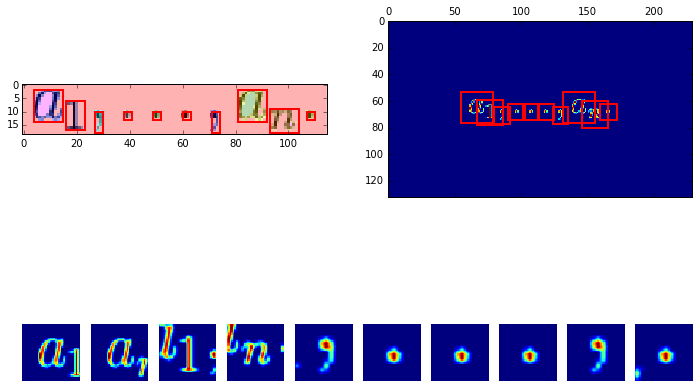

In [28]:
i = 9
image = images[i]
print equations[i]
label_image = skimage.measure.label(image)
image_label_overlay = skimage.color.label2rgb(label_image, image=image)

# add a padding around the inverted image
buff = max(image.shape)/2
padded = np.pad(1-image, buff, mode='minimum')

# plot the labeles image and the padded image
pyplot.subplots(figsize=(12,8))
ax1, ax2 = pyplot.subplot(221), pyplot.subplot(222)
ax1.imshow(image_label_overlay, interpolation='none')
ax2.matshow(padded)

def draw_rect(ax, t,l,b,r):
    ax.add_patch( matplotlib.patches.Rectangle(
        (l, t), r - l, b - t, fill=False, edgecolor='red', linewidth=2) )

parts = []
for region in skimage.measure.regionprops(label_image, 1-image):
    # check if 
    if np.any(region.intensity_image * region.image):
        # plot the normal bounding boxes in the labeled image
        draw_rect(ax1, *region.bbox)
        # plot the scale-invariant boxes in the padded image
        draw_rect(ax2, *get_scaled_bbox(buff, region))
        # extract component from image and scale
        minr, minc, maxr, maxc = get_scaled_bbox(buff, region)
        parts.append(skimage.transform.resize(padded[minr:maxr, minc:maxc], (40,40)))

# plot all scaled components
for i,p in enumerate(parts):
    ax = pyplot.subplot(2,len(parts),len(parts)+1+i)
    ax.set_axis_off()
    ax.matshow(p)

# Sum the scaled components, and flatten into vectors

(54, 1600)

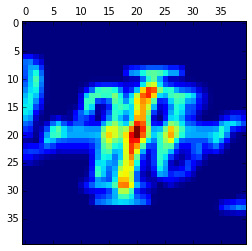

In [6]:
def get_parts(image, label_image = None, size=(40,40)):
    if label_image == None:
        label_image = skimage.measure.label(image)
    buff = max(image.shape)/2
    padded = np.pad(1-image, buff, mode='minimum')
    for region in skimage.measure.regionprops(label_image, 1-image):
        if np.any(region.intensity_image * region.image):
            minr, minc, maxr, maxc = get_scaled_bbox(buff, region)
            part = padded[minr:maxr, minc:maxc]
            yield skimage.transform.resize(part, (40,40))

component_sums = np.vstack([sum(get_parts(img)).flatten() for img in images])
# you get the component-sum image back when you reshape it, it looks funky!
pyplot.matshow(component_sums[-1].reshape(40,40))
component_sums.shape

# Train models

In [7]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import KFold
from sklearn.metrics import f1_score

model = OneVsRestClassifier(SVC(kernel='linear'))

def precision(rel, ret):
    np.where(ret.sum(axis=1)==0, 0, np.true_divide( (rel & ret).sum(axis=1), ret.sum(axis=1) ))

n_fold = 4
kf = KFold(equation_bags.shape[0], n_folds=n_fold, shuffle=True)
test_scores = []
for train, test in kf:
    X_train, X_test = component_sums[train], component_sums[test]
    Y_train, Y_test = equation_bags[train], equation_bags[test]
    
    model.fit(X_train, Y_train)
    test_scores.append( f1_score(Y_test, model.predict(X_test)) )
    
np.mean(test_scores)

0.66471092683824839